In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
from cairo_plot import plot, get_pixel_grid

In [2]:
# ---- Configuration ----
query_id = 25
measure = 1
dataset = "manufacturing_exp"
width = 1000
height = 600
outFolder = "output"

raw_path = f"../{outFolder}/timeRawQueries/raw/influx/{dataset}/run_0/query_{query_id}/{measure}.csv"
pixel_path = f"../{outFolder}/timeQueries/m4/influx/{dataset}/run_0/query_{query_id}/{measure}.csv"

alphabet_size = 5

# ---- Load data ----
df = pd.read_csv(raw_path, skiprows=1, header=None, usecols=[1])
data = df.values.squeeze()
data_z = (data - data.mean()) / data.std()

# ---- Classic SAX ----
breakpoints = norm.ppf(np.linspace(0, 1, alphabet_size + 1)[1:-1])
print("Classic SAX breakpoints:", breakpoints)
sax_symbols = np.digitize(data_z, breakpoints)

# ---- Pixel SAX (min-max, image grid) ----
df_pixel = pd.read_csv(pixel_path)

min_ts = df_pixel['timestamp'].min()
max_ts = df_pixel['timestamp'].max()

img_path = os.path.join(f"{dataset}_{query_id}_{measure}_method.png")
plot(df_pixel, str(measure), img_path.replace('.png', ''), width, height, min_ts, max_ts)

# Get pixel grid and calculate average row indices of black pixels (0) in each column
px_grid = get_pixel_grid(img_path)

# Calculate average of row indices of all 0 pixels in each column
avg_pixel_values = []
for col in range(px_grid.shape[1]):  # iterate through columns
    black_pixel_rows = np.where(px_grid[:, col] == 0)[0]  # find row indices where pixel value is 0
    if len(black_pixel_rows) > 0:
        avg_row = np.mean(black_pixel_rows)  # average of the row indices
        avg_pixel_values.append(avg_row)
    else:
        # If no black pixels in this column, use a default value (e.g., middle of image)
        avg_pixel_values.append(height / 2)

avg_pixel_values = np.array(avg_pixel_values)

# Invert the avg_pixel_values so that symbol 'a' represents bottom of plot (like Classic SAX)
# In image coordinates: 0 = top, height-1 = bottom
# We want: high avg_pixel_values values (bottom of plot) = symbol 'a' (low symbol values)
avg_pixel_values = height - 1 - avg_pixel_values

# Interpolate to match data length if needed
if len(avg_pixel_values) != len(data):
    pixel_indices = np.linspace(0, len(avg_pixel_values) - 1, len(data))
    avg_pixel_values = np.interp(pixel_indices, np.arange(len(avg_pixel_values)), avg_pixel_values)

# Determine pixel-derived breakpoints from pixel quantiles
pixel_breakpoints = np.percentile(avg_pixel_values, np.linspace(0, 100, alphabet_size + 1)[1:-1])
# avg_pixel_values_z = (avg_pixel_values - avg_pixel_values.mean()) / avg_pixel_values.std()
# pixel_breakpoints = norm.ppf(np.linspace(0, 1, alphabet_size + 1)[1:-1])
print(pixel_breakpoints)

# Apply breakpoints to normalized avg_pixel_values
image_sax_symbols = np.digitize(avg_pixel_values, pixel_breakpoints)

# ---- Symbol frequency plot ----
def plot_symbol_freq(*symbol_lists, labels, title):
    indices = np.arange(alphabet_size)
    bar_width = 0.25
    plt.figure(figsize=(10, 5))
    for i, (symbols, label) in enumerate(zip(symbol_lists, labels)):
        unique, counts = np.unique(symbols, return_counts=True)
        freq = counts / counts.sum()
        plt.bar(indices + (i - len(symbol_lists)/2)*bar_width, freq, width=bar_width, label=label)
    plt.xticks(indices, [chr(ord('a') + i) for i in range(alphabet_size)])
    plt.xlabel('Symbol')
    plt.ylabel('Relative Frequency')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_symbol_freq(
    sax_symbols,
    image_sax_symbols,
    labels=['Classic SAX', 'Pixel SAX'],
    title='SAX Symbol Frequencies'
)

# ---- Colored time series plot (pick any symbolization) ----
from matplotlib.colors import ListedColormap
symbol_colors = ListedColormap(['#f8766d', '#ffd700', '#00ba38', '#619cff', '#9933ff'])
def plot_colored_timeseries(data_values, symbols, method_label, ylabel='Value'):
    plt.figure(figsize=(14, 5))
    for symbol in range(alphabet_size):
        idx = np.where(symbols == symbol)[0]
        plt.plot(idx, data_values[idx], '.', color=symbol_colors(symbol), label=f'{chr(97+symbol)}', alpha=0.8, markersize=3)
    plt.title(f'Time Series with {method_label} (alphabet size {alphabet_size})')
    plt.ylabel(ylabel)
    plt.xlabel('Time')
    plt.legend(title='Symbol')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot Classic SAX with z-normalized data
plot_colored_timeseries(data_z, sax_symbols, 'Classic SAX', 'Z-normalized Value')

# Plot Pixel SAX with original data values (not z-normalized)
plot_colored_timeseries(data, image_sax_symbols, 'Pixel SAX', 'Original Value')


FileNotFoundError: [Errno 2] No such file or directory: '../output/timeRawQueries/raw/influx/manufacturing_exp/run_0/query_25/1.csv'

In [ ]:
breakpoints = norm.ppf(np.linspace(0.66, 1, alphabet_size + 1,)[1:-1], scale = height // 2 )
# breakpoints += abs(breakpoints[0])
breakpoints


array([182.03260905, 248.22549621, 329.5405261 , 447.25600657])

In [ ]:
query_id = 40
measure = 1
dataset = "manufacturing_exp"
width = 1000
height = 600
outFolder = "output"

## Slope Comparison Analysis

This section compares the slopes of the raw time series data against the slopes derived from the image reconstruction using actual timestamps.

Raw data timestamp range: 1330145525760 to 1330146050040
Image data timestamp range: 1330145525760 to 1330146049750
\nData duration per point: 10.00
Window durations to test: ['999.98', '2499.95', '4999.90', '9999.81']


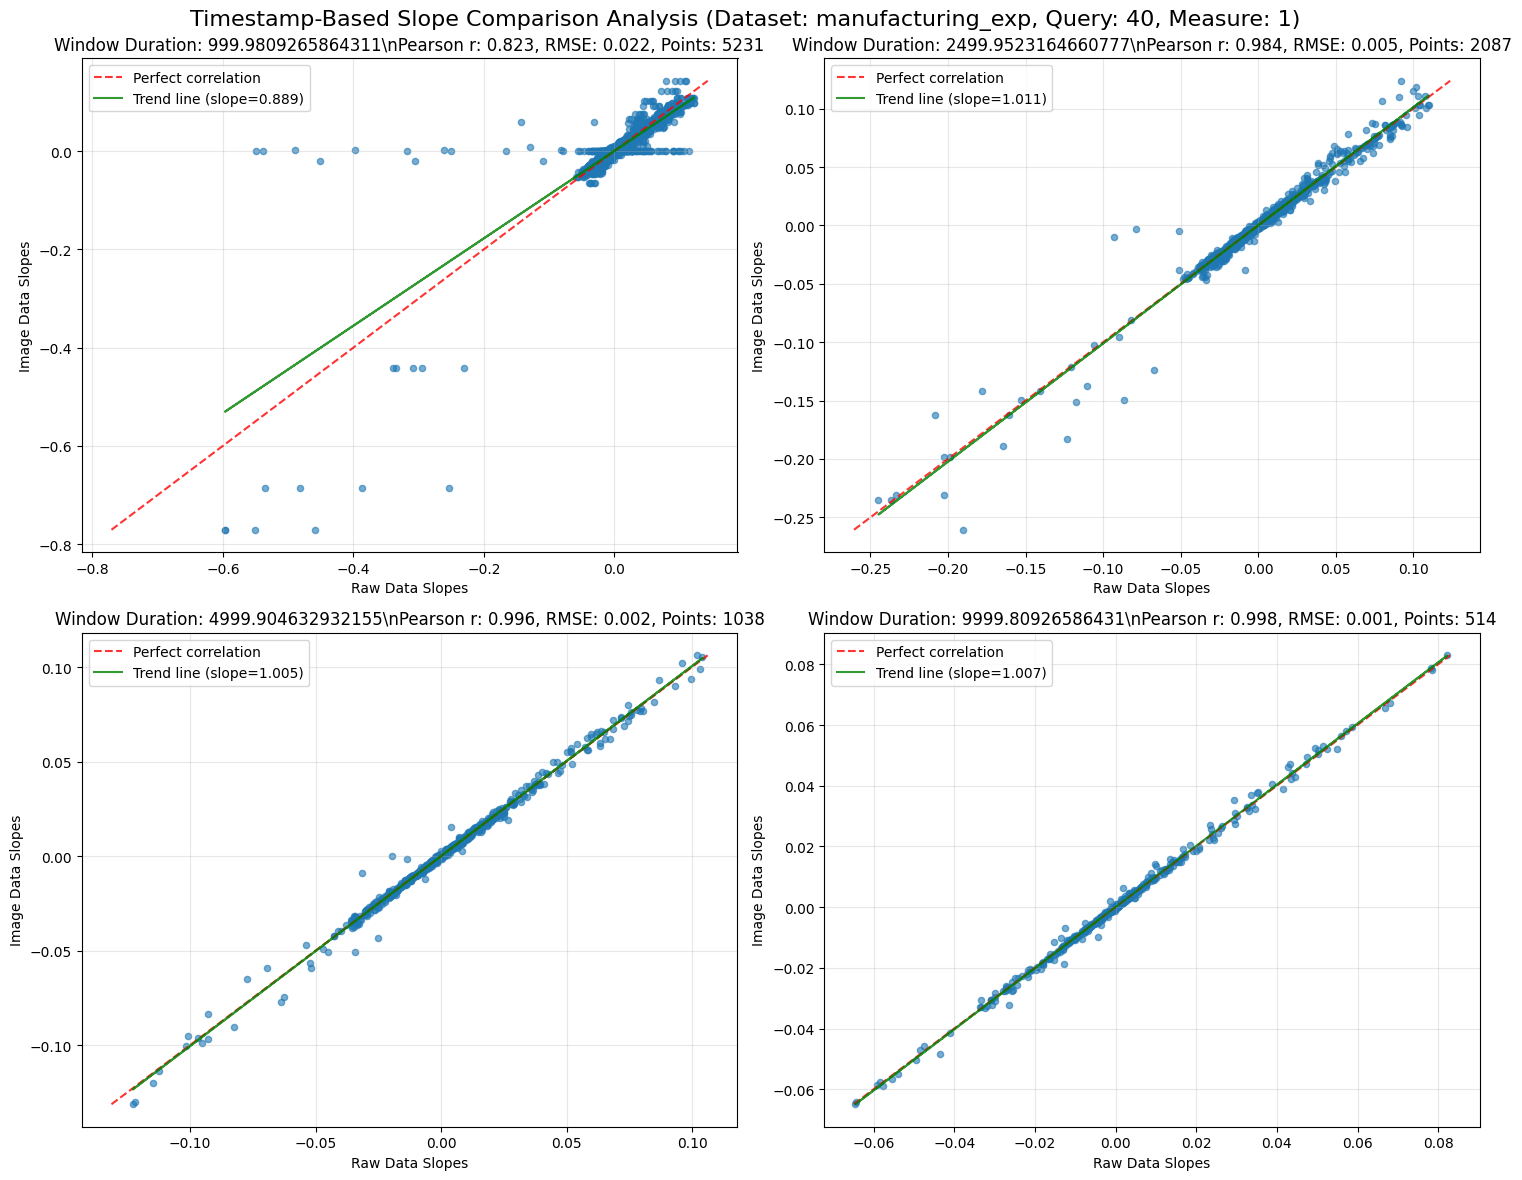


TIMESTAMP-BASED SLOPE COMPARISON RESULTS

Window Duration: 999.98
  Pearson Correlation: 0.8230 (p-value: 0.00e+00)
  Spearman Correlation: 0.9258 (p-value: 0.00e+00)
  RMSE: 0.0224
  MAE: 0.0053
  MSE: 0.0005
  Number of aligned slope pairs: 5231
  Raw windows: 5233, Image windows: 5231

Window Duration: 2499.95
  Pearson Correlation: 0.9840 (p-value: 0.00e+00)
  Spearman Correlation: 0.9928 (p-value: 0.00e+00)
  RMSE: 0.0050
  MAE: 0.0017
  MSE: 0.0000
  Number of aligned slope pairs: 2087
  Raw windows: 2088, Image windows: 2087

Window Duration: 4999.90
  Pearson Correlation: 0.9961 (p-value: 0.00e+00)
  Spearman Correlation: 0.9955 (p-value: 0.00e+00)
  RMSE: 0.0021
  MAE: 0.0010
  MSE: 0.0000
  Number of aligned slope pairs: 1038
  Raw windows: 1039, Image windows: 1038

Window Duration: 9999.81
  Pearson Correlation: 0.9984 (p-value: 0.00e+00)
  Spearman Correlation: 0.9977 (p-value: 0.00e+00)
  RMSE: 0.0011
  MAE: 0.0006
  MSE: 0.0000
  Number of aligned slope pairs: 514
  Raw

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_slopes_with_timestamps(timestamps, values, window_duration):
    """
    Calculate slopes for time-based sliding windows using actual timestamps.
    
    Parameters:
    -----------
    timestamps : array-like
        Timestamp values (in same units as window_duration)
    values : array-like
        Data values corresponding to timestamps
    window_duration : float
        Duration of each sliding window in timestamp units
        
    Returns:
    --------
    tuple
        (window_centers, slopes) where window_centers are the center timestamps
        of each window and slopes are the calculated slope values
    """
    timestamps = np.array(timestamps)
    values = np.array(values)
    
    # Find the time range
    start_time = timestamps.min()
    end_time = timestamps.max()
    
    # Create sliding windows
    window_centers = []
    slopes = []
    
    # Start from the first possible window center
    current_center = start_time + window_duration / 2
    
    while current_center + window_duration / 2 <= end_time:
        # Define window boundaries
        window_start = current_center - window_duration / 2
        window_end = current_center + window_duration / 2
        
        # Find data points within this window
        window_mask = (timestamps >= window_start) & (timestamps <= window_end)
        window_times = timestamps[window_mask]
        window_vals = values[window_mask]
        
        # Calculate slope if we have enough points
        if len(window_times) >= 2:
            # Use linear regression to calculate slope
            slope = np.polyfit(window_times, window_vals, 1)[0]
            window_centers.append(current_center)
            slopes.append(slope)
        
        # Move to next window (overlap windows by 90% for more data points)
        current_center += window_duration * 0.1
    
    return np.array(window_centers), np.array(slopes)

def align_slope_data(raw_centers, raw_slopes, image_centers, image_slopes, tolerance=None):
    """
    Align slope data from raw and image datasets based on timestamps.
    
    Parameters:
    -----------
    raw_centers : array-like
        Center timestamps for raw data slopes
    raw_slopes : array-like
        Slope values for raw data
    image_centers : array-like
        Center timestamps for image data slopes
    image_slopes : array-like
        Slope values for image data
    tolerance : float, optional
        Maximum time difference for alignment. If None, uses 10% of minimum window spacing
        
    Returns:
    --------
    tuple
        (aligned_raw_slopes, aligned_image_slopes, aligned_centers)
    """
    if tolerance is None:
        # Use 10% of the minimum spacing as tolerance
        raw_spacing = np.min(np.diff(raw_centers)) if len(raw_centers) > 1 else 1
        image_spacing = np.min(np.diff(image_centers)) if len(image_centers) > 1 else 1
        tolerance = 0.1 * min(raw_spacing, image_spacing)
    
    aligned_raw = []
    aligned_image = []
    aligned_centers = []
    
    # For each raw data point, find the closest image data point
    for i, raw_center in enumerate(raw_centers):
        # Find the closest image center
        distances = np.abs(image_centers - raw_center)
        closest_idx = np.argmin(distances)
        
        # Check if it's within tolerance
        if distances[closest_idx] <= tolerance:
            aligned_raw.append(raw_slopes[i])
            aligned_image.append(image_slopes[closest_idx])
            aligned_centers.append(raw_center)
    
    return np.array(aligned_raw), np.array(aligned_image), np.array(aligned_centers)

def compare_slopes_timestamp_based(raw_df, image_df, window_durations, title_suffix=""):
    """
    Compare slopes between raw data and image-derived data using timestamp-based windows.
    
    Parameters:
    -----------
    raw_df : pandas.DataFrame
        Raw data with 'timestamp' and value columns
    image_df : pandas.DataFrame
        Image data with 'timestamp' and value columns
    window_durations : list
        List of window durations to test (in timestamp units)
    title_suffix : str
        Additional text for plot titles
    """
    
    results = []
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Timestamp-Based Slope Comparison Analysis {title_suffix}', fontsize=16)
    
    for i, window_duration in enumerate(window_durations):
        if i >= 4:  # Only plot first 4 results
            break
        
        # Calculate slopes for both datasets using timestamps
        raw_centers, raw_slopes = calculate_slopes_with_timestamps(
            raw_df['timestamp'], raw_df['value'], window_duration
        )
        image_centers, image_slopes = calculate_slopes_with_timestamps(
            image_df['timestamp'], image_df.iloc[:, 1], window_duration
        )

        # Align the slope data based on timestamps
        aligned_raw_slopes, aligned_image_slopes, aligned_centers = align_slope_data(
            raw_centers, raw_slopes, image_centers, image_slopes
        )
        
        if len(aligned_raw_slopes) < 2:
            print(f"Warning: Not enough aligned data points for window duration {window_duration}")
            continue
        
        # Calculate correlation metrics
        pearson_corr, pearson_p = pearsonr(aligned_raw_slopes, aligned_image_slopes)
        spearman_corr, spearman_p = spearmanr(aligned_raw_slopes, aligned_image_slopes)
        
        # Calculate error metrics
        mse = mean_squared_error(aligned_raw_slopes, aligned_image_slopes)
        mae = mean_absolute_error(aligned_raw_slopes, aligned_image_slopes)
        rmse = np.sqrt(mse)
        
        # Store results
        results.append({
            'window_duration': window_duration,
            'pearson_corr': pearson_corr,
            'pearson_p': pearson_p,
            'spearman_corr': spearman_corr,
            'spearman_p': spearman_p,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'raw_slopes': aligned_raw_slopes,
            'image_slopes': aligned_image_slopes,
            'aligned_centers': aligned_centers,
            'raw_centers': raw_centers,
            'image_centers': image_centers
        })
        
        # Plot results
        ax = axes[i//2, i%2]
        
        # Scatter plot of slopes
        ax.scatter(aligned_raw_slopes, aligned_image_slopes, alpha=0.6, s=20)
        
        # Add diagonal line for perfect correlation
        min_slope = min(np.min(aligned_raw_slopes), np.min(aligned_image_slopes))
        max_slope = max(np.max(aligned_raw_slopes), np.max(aligned_image_slopes))
        ax.plot([min_slope, max_slope], [min_slope, max_slope], 'r--', alpha=0.8, label='Perfect correlation')
        
        # Add trend line
        z = np.polyfit(aligned_raw_slopes, aligned_image_slopes, 1)
        p = np.poly1d(z)
        ax.plot(aligned_raw_slopes, p(aligned_raw_slopes), 'g-', alpha=0.8, label=f'Trend line (slope={z[0]:.3f})')
        
        ax.set_xlabel('Raw Data Slopes')
        ax.set_ylabel('Image Data Slopes')
        ax.set_title(f'Window Duration: {window_duration}\\n'
                    f'Pearson r: {pearson_corr:.3f}, RMSE: {rmse:.3f}, Points: {len(aligned_raw_slopes)}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    return results

# Load the data with timestamps

raw_path = f"../{outFolder}/timeRawQueries/raw/influx/{dataset}/run_0/query_{query_id}/{measure}.csv"
pixel_path = f"../{outFolder}/timeQueries/m4/influx/{dataset}/run_0/query_{query_id}/{measure}.csv"

raw_df = pd.read_csv(raw_path, skiprows=1, header=None, names=['timestamp', 'value'])
image_df = pd.read_csv(pixel_path)

# Convert timestamps to same scale if needed
print("Raw data timestamp range:", raw_df['timestamp'].min(), "to", raw_df['timestamp'].max())
print("Image data timestamp range:", image_df['timestamp'].min(), "to", image_df['timestamp'].max())

# Calculate appropriate window durations based on the data
time_range = raw_df['timestamp'].max() - raw_df['timestamp'].min()
data_duration = time_range / len(raw_df)  # Average time per data point

# Define window durations as multiples of data duration
# This ensures larger segments as requested
window_durations = [
    data_duration * 100,   # ~100 data points
    data_duration * 250,   # ~250 data points
    data_duration * 500,   # ~500 data points
    data_duration * 1000,  # ~1000 data points
]

print(f"\\nData duration per point: {data_duration:.2f}")
print(f"Window durations to test: {[f'{wd:.2f}' for wd in window_durations]}")

# Run the timestamp-based comparison
slope_results_timestamp = compare_slopes_timestamp_based(
    raw_df, 
    image_df, 
    window_durations, 
    title_suffix=f"(Dataset: {dataset}, Query: {query_id}, Measure: {measure})"
)

# Print detailed results
print("\n" + "="*80)
print("TIMESTAMP-BASED SLOPE COMPARISON RESULTS")
print("="*80)

for result in slope_results_timestamp:
    print(f"\nWindow Duration: {result['window_duration']:.2f}")
    print(f"  Pearson Correlation: {result['pearson_corr']:.4f} (p-value: {result['pearson_p']:.2e})")
    print(f"  Spearman Correlation: {result['spearman_corr']:.4f} (p-value: {result['spearman_p']:.2e})")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  MAE: {result['mae']:.4f}")
    print(f"  MSE: {result['mse']:.4f}")
    print(f"  Number of aligned slope pairs: {len(result['raw_slopes'])}")
    print(f"  Raw windows: {len(result['raw_centers'])}, Image windows: {len(result['image_centers'])}")

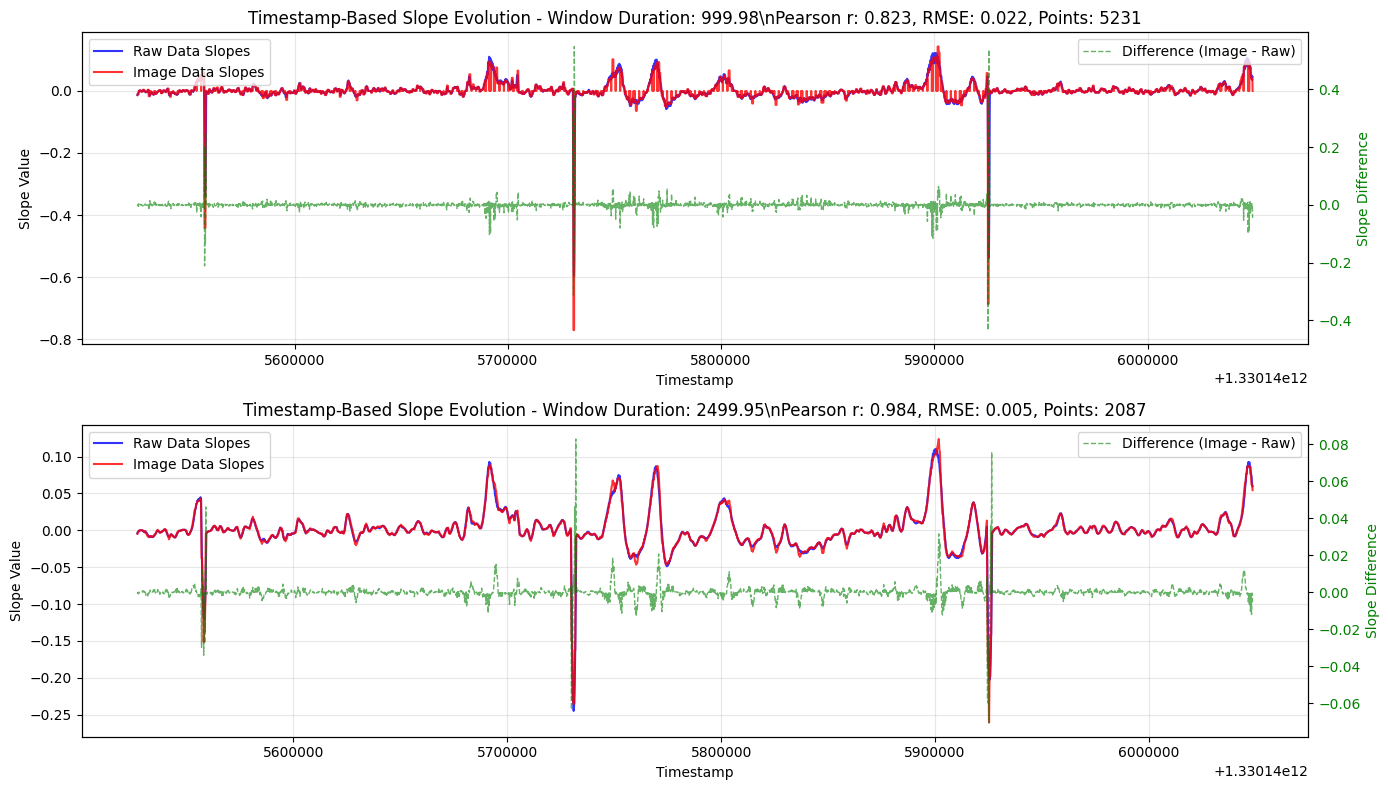


TIMESTAMP-BASED SLOPE COMPARISON SUMMARY TABLE
Window Duration Pearson r  Spearman r  RMSE     MAE      Points  
--------------------------------------------------------------------------------
999.98          0.823      0.926       0.022    0.005    5231    
2499.95         0.984      0.993       0.005    0.002    2087    
4999.90         0.996      0.995       0.002    0.001    1038    
9999.81         0.998      0.998       0.001    0.001    514     

Best Performance by Criteria:
  Highest Pearson correlation: Window duration 9999.81 (r = 0.998)
  Highest Spearman correlation: Window duration 9999.81 (ρ = 0.998)
  Lowest RMSE: Window duration 9999.81 (RMSE = 0.001)

Overall Performance (Timestamp-Based):
  Average Pearson correlation: 0.950
  Average Spearman correlation: 0.978
  Average RMSE: 0.008

✓ Strong positive correlation between raw and image slopes

Conclusion: The timestamp-based image approach captures the slope trends with high fidelity (r = 0.950)


In [ ]:
def plot_timestamp_slope_evolution(slope_results, max_plots=2):
    """
    Plot the evolution of slopes over time using timestamp-based windows.
    
    Parameters:
    -----------
    slope_results : list
        Results from compare_slopes_timestamp_based function
    max_plots : int
        Maximum number of window durations to plot
    """
    
    fig, axes = plt.subplots(max_plots, 1, figsize=(14, 4*max_plots))
    if max_plots == 1:
        axes = [axes]
    
    for i, result in enumerate(slope_results[:max_plots]):
        window_duration = result['window_duration']
        aligned_raw_slopes = result['raw_slopes']
        aligned_image_slopes = result['image_slopes']
        aligned_centers = result['aligned_centers']
        
        ax = axes[i]
        
        # Plot both slope series against time
        ax.plot(aligned_centers, aligned_raw_slopes, 'b-', alpha=0.8, linewidth=1.5, label='Raw Data Slopes')
        ax.plot(aligned_centers, aligned_image_slopes, 'r-', alpha=0.8, linewidth=1.5, label='Image Data Slopes')
        
        # Calculate and plot difference
        slope_diff = aligned_image_slopes - aligned_raw_slopes
        ax2 = ax.twinx()
        ax2.plot(aligned_centers, slope_diff, 'g--', alpha=0.6, linewidth=1, label='Difference (Image - Raw)')
        ax2.set_ylabel('Slope Difference', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        
        # Add statistics to the plot
        pearson_corr = result['pearson_corr']
        rmse = result['rmse']
        
        ax.set_title(f'Timestamp-Based Slope Evolution - Window Duration: {window_duration:.2f}\\n'
                    f'Pearson r: {pearson_corr:.3f}, RMSE: {rmse:.3f}, Points: {len(aligned_raw_slopes)}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Slope Value')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot slope evolution for the first two window durations
if len(slope_results_timestamp) > 0:
    plot_timestamp_slope_evolution(slope_results_timestamp, max_plots=min(2, len(slope_results_timestamp)))
    
    # Create a summary table
    print("\n" + "="*80)
    print("TIMESTAMP-BASED SLOPE COMPARISON SUMMARY TABLE")
    print("="*80)
    
    print(f"{'Window Duration':<15} {'Pearson r':<10} {'Spearman r':<11} {'RMSE':<8} {'MAE':<8} {'Points':<8}")
    print("-" * 80)
    
    for result in slope_results_timestamp:
        print(f"{result['window_duration']:<15.2f} {result['pearson_corr']:<10.3f} {result['spearman_corr']:<11.3f} "
              f"{result['rmse']:<8.3f} {result['mae']:<8.3f} {len(result['raw_slopes']):<8}")
    
    # Find the best window duration based on different criteria
    best_pearson = max(slope_results_timestamp, key=lambda x: x['pearson_corr'])
    best_spearman = max(slope_results_timestamp, key=lambda x: x['spearman_corr'])
    best_rmse = min(slope_results_timestamp, key=lambda x: x['rmse'])
    
    print(f"\nBest Performance by Criteria:")
    print(f"  Highest Pearson correlation: Window duration {best_pearson['window_duration']:.2f} (r = {best_pearson['pearson_corr']:.3f})")
    print(f"  Highest Spearman correlation: Window duration {best_spearman['window_duration']:.2f} (ρ = {best_spearman['spearman_corr']:.3f})")
    print(f"  Lowest RMSE: Window duration {best_rmse['window_duration']:.2f} (RMSE = {best_rmse['rmse']:.3f})")
    
    # Calculate overall performance metrics
    mean_pearson = np.mean([r['pearson_corr'] for r in slope_results_timestamp])
    mean_spearman = np.mean([r['spearman_corr'] for r in slope_results_timestamp])
    mean_rmse = np.mean([r['rmse'] for r in slope_results_timestamp])
    
    print(f"\nOverall Performance (Timestamp-Based):")
    print(f"  Average Pearson correlation: {mean_pearson:.3f}")
    print(f"  Average Spearman correlation: {mean_spearman:.3f}")
    print(f"  Average RMSE: {mean_rmse:.3f}")
    
    # Determine if correlations are generally strong
    if mean_pearson > 0.7:
        print("\n✓ Strong positive correlation between raw and image slopes")
    elif mean_pearson > 0.5:
        print("\n○ Moderate positive correlation between raw and image slopes")
    else:
        print("\n✗ Weak correlation between raw and image slopes")
    
    print(f"\nConclusion: The timestamp-based image approach captures the slope trends with "
          f"{'high' if mean_pearson > 0.7 else 'moderate' if mean_pearson > 0.5 else 'low'} fidelity "
          f"(r = {mean_pearson:.3f})")

else:
    print("No slope results to display.")

Starting CORRECTED slope method comparison...
Key fix: Pixel slopes are now aggregated at the same temporal scale as sliding windows

Extracting pixel slopes from M4-aggregated plot...
M4 data range: 14512.000 to 15466.000
Time range: 1330145525760.000 to 1330146049750.000
M4 data points: 4000, Raw data points: 52429
Pixel extraction scaling - Time: 523.990000 per pixel, Value: 1.590000 per pixel
This gives us 1000 slope measurements across the entire time range
Pixel method gradient: 1000 slopes, range: [-0.385370, 0.138066], mean: 0.000781
Pixel extraction scaling - Time: 523.990000 per pixel, Value: 1.590000 per pixel
This gives us 1000 slope measurements across the entire time range
Pixel method finite_difference: 1000 slopes, range: [-0.391439, 0.144134], mean: 0.000757

COMPARING DIFFERENT WINDOW SIZES

--- Window Duration: 999.98 ---
Raw sliding windows: 5233 slopes
M4 sliding windows: 5231 slopes
Raw slopes range: [-0.596790, 0.122422], mean: 0.000800
M4 slopes range: [-0.77086

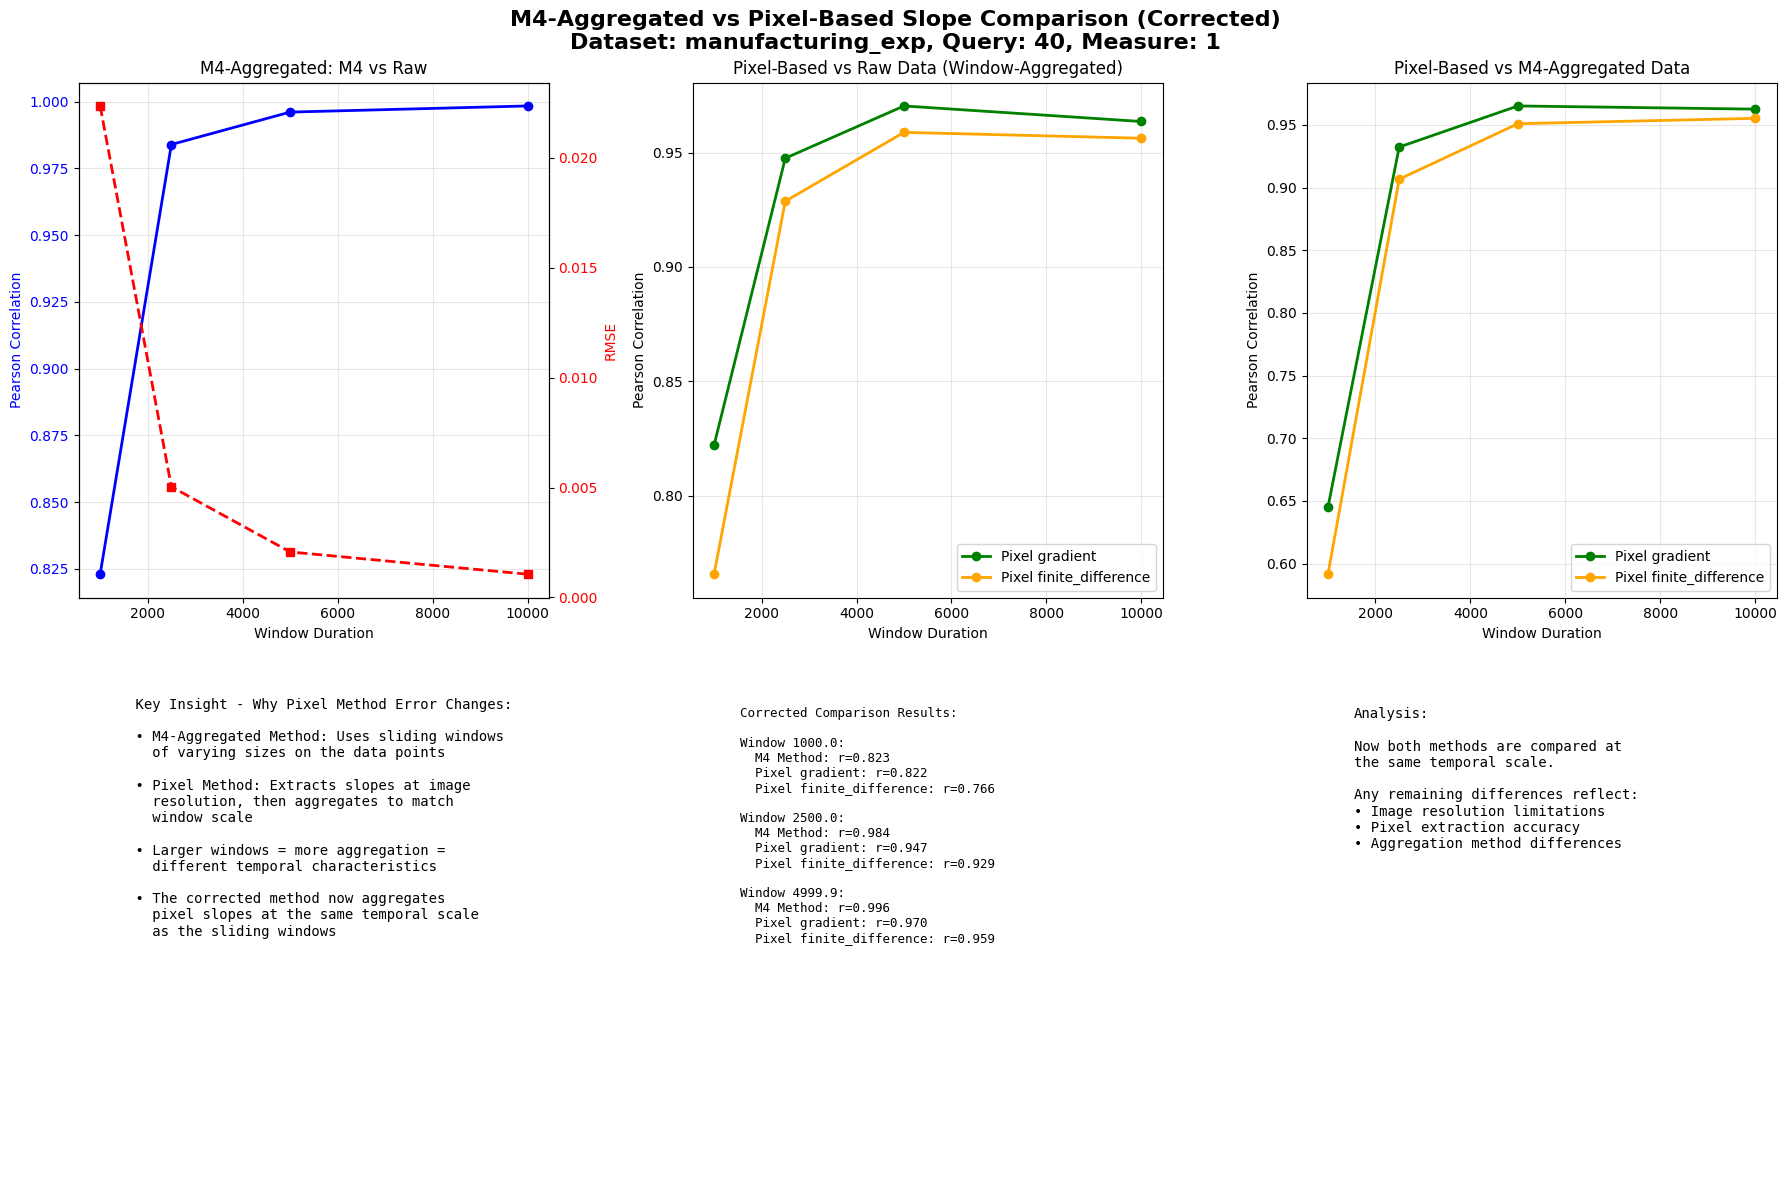


CORRECTED SLOPE METHOD COMPARISON SUMMARY

Dataset: manufacturing_exp
Query ID: 40
Measure: 1

--- CORRECTED RESULTS BY WINDOW ---

Window 999.98:
  M4-Aggregated vs Raw: r = 0.823
  Pixel gradient vs Raw: r = 0.822
  Pixel finite_difference vs Raw: r = 0.766

Window 2499.95:
  M4-Aggregated vs Raw: r = 0.984
  Pixel gradient vs Raw: r = 0.947
  Pixel finite_difference vs Raw: r = 0.929

Window 4999.90:
  M4-Aggregated vs Raw: r = 0.996
  Pixel gradient vs Raw: r = 0.970
  Pixel finite_difference vs Raw: r = 0.959

Window 9999.81:
  M4-Aggregated vs Raw: r = 0.998
  Pixel gradient vs Raw: r = 0.964
  Pixel finite_difference vs Raw: r = 0.956

Corrected comparison completed successfully!


In [ ]:
# Pixel-Based vs M4-Aggregated Slope Comparison
# This cell compares M4-aggregated slope method with pixel-based slope extraction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cairo_plot import plot, get_pixel_grid

def extract_pixel_slopes(image_path, method='gradient', image_df=None, width=1000, height=600):
    """
    Extract slope information directly from generated plot images with proper scaling
    
    Note: Pixel slopes are extracted at the image resolution level, which is independent
    of the sliding window size used for M4-aggregated slope calculations.
    
    Parameters:
    -----------
    image_path : str
        Path to the plot image
    method : str
        Method for slope extraction ('gradient', 'finite_difference')
    image_df : pandas.DataFrame
        M4-aggregated data with actual values for scaling conversion
    width : int
        Image width in pixels
    height : int
        Image height in pixels
        
    Returns:
    --------
    numpy.array: Array of slope values scaled to data coordinates
    """
    try:
        # Get pixel grid from image
        px_grid = get_pixel_grid(image_path)
        
        # Extract the main line pixels from the plot
        line_pixels = extract_line_pixels_advanced(px_grid)
        
        if len(line_pixels) < 2:
            return np.array([])
        
        # Calculate scaling factors from pixel coordinates to data coordinates
        if image_df is not None:
            # Time scaling: pixel columns to timestamp range
            time_range = image_df['timestamp'].max() - image_df['timestamp'].min()
            time_scale = time_range / px_grid.shape[1]  # timestamp units per pixel column
            
            # Value scaling: pixel rows to data value range
            value_range = image_df.iloc[:, 1].max() - image_df.iloc[:, 1].min()
            value_scale = value_range / px_grid.shape[0]  # data units per pixel row
            
            print(f"Pixel extraction scaling - Time: {time_scale:.6f} per pixel, Value: {value_scale:.6f} per pixel")
            print(f"This gives us {px_grid.shape[1]} slope measurements across the entire time range")
        else:
            # Fallback scaling (this won't be accurate)
            time_scale = 1.0
            value_scale = 1.0
            print("Warning: No scaling data provided, using unit scaling")
        
        if method == 'gradient':
            # Calculate slopes using numpy gradient
            x_coords = line_pixels[:, 1]  # column positions (time dimension)
            y_coords = line_pixels[:, 0]  # row positions (value dimension)
            
            # Invert y-coordinates so higher values are at top
            y_coords = px_grid.shape[0] - y_coords
            
            # Calculate slope using gradient
            if len(x_coords) > 1:
                # Calculate pixel slopes
                pixel_slopes = np.gradient(y_coords, x_coords)
                
                # Convert to data coordinate slopes: (data_units/pixel_row) / (time_units/pixel_col)
                scaled_slopes = pixel_slopes * (value_scale / time_scale)
            else:
                scaled_slopes = np.array([0])
                
        elif method == 'finite_difference':
            # Calculate slopes using finite differences
            x_coords = line_pixels[:, 1]  # column positions (time dimension)
            y_coords = px_grid.shape[0] - line_pixels[:, 0]  # Invert y-coordinates
            
            slopes = []
            for i in range(1, len(x_coords)):
                if x_coords[i] != x_coords[i-1]:
                    # Calculate pixel slope
                    pixel_slope = (y_coords[i] - y_coords[i-1]) / (x_coords[i] - x_coords[i-1])
                    # Convert to data coordinate slope
                    data_slope = pixel_slope * (value_scale / time_scale)
                    slopes.append(data_slope)
                else:
                    slopes.append(0 if len(slopes) == 0 else slopes[-1])
            
            # Add first slope
            if len(slopes) > 0:
                slopes = [slopes[0]] + slopes
            else:
                slopes = [0]
                
            scaled_slopes = np.array(slopes)
        
        return scaled_slopes
    except Exception as e:
        print(f"Error extracting pixel slopes: {e}")
        return np.array([])

def extract_line_pixels_advanced(px_grid):
    """
    Advanced line pixel extraction that handles multiple black pixels per column
    """
    line_pixels = []
    height, width = px_grid.shape
    
    for col in range(width):
        black_pixels = np.where(px_grid[:, col] == 0)[0]
        
        if len(black_pixels) > 0:
            # Use median of black pixels for robustness
            median_y = np.median(black_pixels)
            line_pixels.append([median_y, col])
        elif len(line_pixels) > 0:
            # Interpolate from previous point
            line_pixels.append([line_pixels[-1][0], col])
        else:
            # Use middle of image as default
            line_pixels.append([height / 2, col])
    
    return np.array(line_pixels)

def align_pixel_slopes_to_timestamps(pixel_slopes, image_df, target_timestamps):
    """
    Align pixel-derived slopes to specific timestamps using interpolation
    """
    if len(pixel_slopes) == 0 or len(image_df) == 0:
        return np.array([])
    
    # Create timestamp array for pixel slopes
    pixel_timestamps = np.linspace(
        image_df['timestamp'].min(),
        image_df['timestamp'].max(),
        len(pixel_slopes)
    )
    
    # Interpolate to target timestamps
    aligned_slopes = np.interp(target_timestamps, pixel_timestamps, pixel_slopes)
    
    return aligned_slopes

def calculate_pixel_slopes_at_window_scale(pixel_slopes, window_duration, image_df):
    """
    Calculate pixel-based slopes at the same temporal scale as sliding windows.
    
    This addresses the issue where pixel slopes are at image resolution while
    M4-aggregated slopes are calculated over larger windows.
    
    Parameters:
    -----------
    pixel_slopes : array-like
        High-resolution pixel slopes
    window_duration : float
        Duration of sliding window used for M4-aggregated slopes
    image_df : pandas.DataFrame
        M4-aggregated data for time scaling
        
    Returns:
    --------
    tuple: (window_centers, aggregated_pixel_slopes)
    """
    if len(pixel_slopes) == 0:
        return np.array([]), np.array([])
    
    # Create timestamp array for pixel slopes
    pixel_timestamps = np.linspace(
        image_df['timestamp'].min(),
        image_df['timestamp'].max(),
        len(pixel_slopes)
    )
    
    # Create sliding windows similar to M4-aggregated slope calculation
    start_time = pixel_timestamps.min()
    end_time = pixel_timestamps.max()
    
    window_centers = []
    aggregated_slopes = []
    
    current_center = start_time + window_duration / 2
    
    while current_center + window_duration / 2 <= end_time:
        window_start = current_center - window_duration / 2
        window_end = current_center + window_duration / 2
        
        # Find pixel slopes within this window
        window_mask = (pixel_timestamps >= window_start) & (pixel_timestamps <= window_end)
        window_pixel_slopes = pixel_slopes[window_mask]
        
        if len(window_pixel_slopes) > 0:
            # Aggregate pixel slopes (using mean for now, could use other methods)
            aggregated_slope = np.mean(window_pixel_slopes)
            window_centers.append(current_center)
            aggregated_slopes.append(aggregated_slope)
        
        # Move to next window (same overlap as M4-aggregated method)
        current_center += window_duration * 0.1
    
    return np.array(window_centers), np.array(aggregated_slopes)

def compare_all_slope_methods_corrected(query_id, measure, dataset, window_durations, outFolder):
    """
    Compare M4-aggregated slopes vs pixel-based slopes with proper temporal alignment
    """
    
    # Load data
    raw_path = f"../{outFolder}/timeRawQueries/raw/influx/{dataset}/run_0/query_{query_id}/{measure}.csv"
    m4_path = f"../{outFolder}/timeQueries/m4/influx/{dataset}/run_0/query_{query_id}/{measure}.csv"
    
    raw_df = pd.read_csv(raw_path, skiprows=1, header=None, names=['timestamp', 'value'])
    m4_df = pd.read_csv(m4_path)
    
    # Generate image for pixel analysis
    min_ts = m4_df['timestamp'].min()
    max_ts = m4_df['timestamp'].max()
    img_path = f"{dataset}_{query_id}_{measure}_comparison.png"
    plot(m4_df, str(measure), img_path.replace('.png', ''), 1000, 600, min_ts, max_ts)
    
    results = {
        'dataset': dataset,
        'query_id': query_id,
        'measure': measure,
        'window_results': [],
        'pixel_results': []
    }
    
    # 1. Extract pixel-based slopes (at image resolution)
    pixel_methods = ['gradient', 'finite_difference']
    pixel_slopes_dict = {}
    
    print(f"\nExtracting pixel slopes from M4-aggregated plot...")
    print(f"M4 data range: {m4_df.iloc[:, 1].min():.3f} to {m4_df.iloc[:, 1].max():.3f}")
    print(f"Time range: {m4_df['timestamp'].min():.3f} to {m4_df['timestamp'].max():.3f}")
    print(f"M4 data points: {len(m4_df)}, Raw data points: {len(raw_df)}")
    
    for pixel_method in pixel_methods:
        pixel_slopes = extract_pixel_slopes(img_path, method=pixel_method, image_df=m4_df, 
                                          width=1000, height=600)
        if len(pixel_slopes) > 0:
            pixel_slopes_dict[pixel_method] = pixel_slopes
            
            results['pixel_results'].append({
                'method': pixel_method,
                'num_slopes': len(pixel_slopes),
                'mean_slope': np.mean(pixel_slopes),
                'std_slope': np.std(pixel_slopes),
                'slope_range': [np.min(pixel_slopes), np.max(pixel_slopes)]
            })
            
            print(f"Pixel method {pixel_method}: {len(pixel_slopes)} slopes, "
                  f"range: [{np.min(pixel_slopes):.6f}, {np.max(pixel_slopes):.6f}], "
                  f"mean: {np.mean(pixel_slopes):.6f}")
    
    # 2. Calculate M4-aggregated slopes for each window duration
    print(f"\n" + "="*80)
    print("COMPARING DIFFERENT WINDOW SIZES")
    print("="*80)
    
    for window_duration in window_durations:
        try:
            print(f"\n--- Window Duration: {window_duration:.2f} ---")
            
            # Calculate M4-aggregated slopes using sliding windows
            raw_centers, raw_slopes = calculate_slopes_with_timestamps(
                raw_df['timestamp'], raw_df['value'], window_duration
            )
            m4_centers, m4_slopes = calculate_slopes_with_timestamps(
                m4_df['timestamp'], m4_df.iloc[:, 1], window_duration
            )
            
            print(f"Raw sliding windows: {len(raw_slopes)} slopes")
            print(f"M4 sliding windows: {len(m4_slopes)} slopes")
            
            # Print slope ranges for comparison
            if len(raw_slopes) > 0:
                print(f"Raw slopes range: [{np.min(raw_slopes):.6f}, {np.max(raw_slopes):.6f}], mean: {np.mean(raw_slopes):.6f}")
            if len(m4_slopes) > 0:
                print(f"M4 slopes range: [{np.min(m4_slopes):.6f}, {np.max(m4_slopes):.6f}], mean: {np.mean(m4_slopes):.6f}")
            
            # Align M4-aggregated slopes
            aligned_raw_slopes, aligned_m4_slopes, aligned_centers = align_slope_data(
                raw_centers, raw_slopes, m4_centers, m4_slopes
            )
            
            window_result = {
                'window_duration': window_duration,
                'm4_aggregated_metrics': {},
                'pixel_vs_raw_metrics': {},
                'pixel_vs_m4_metrics': {},
                'raw_slopes': aligned_raw_slopes,
                'm4_slopes': aligned_m4_slopes,
                'aligned_centers': aligned_centers
            }
            
            # M4-aggregated vs Raw correlation
            if len(aligned_raw_slopes) > 1 and len(aligned_m4_slopes) > 1:
                pearson_corr, pearson_p = pearsonr(aligned_raw_slopes, aligned_m4_slopes)
                spearman_corr, spearman_p = spearmanr(aligned_raw_slopes, aligned_m4_slopes)
                rmse = np.sqrt(mean_squared_error(aligned_raw_slopes, aligned_m4_slopes))
                mae = mean_absolute_error(aligned_raw_slopes, aligned_m4_slopes)
                
                window_result['m4_aggregated_metrics'] = {
                    'pearson_corr': pearson_corr,
                    'pearson_p': pearson_p,
                    'spearman_corr': spearman_corr,
                    'spearman_p': spearman_p,
                    'rmse': rmse,
                    'mae': mae,
                    'num_points': len(aligned_raw_slopes)
                }
                
                print(f"M4 vs Raw correlation: {pearson_corr:.3f}")
            
            # 3. Calculate pixel slopes at the SAME window scale
            for pixel_method, pixel_slopes in pixel_slopes_dict.items():
                print(f"\nProcessing pixel method: {pixel_method}")
                
                # THIS IS THE KEY FIX: Aggregate pixel slopes at the same temporal scale
                pixel_window_centers, aggregated_pixel_slopes = calculate_pixel_slopes_at_window_scale(
                    pixel_slopes, window_duration, m4_df
                )
                
                print(f"Pixel slopes aggregated to window scale: {len(aggregated_pixel_slopes)} slopes")
                if len(aggregated_pixel_slopes) > 0:
                    print(f"Aggregated pixel slopes range: [{np.min(aggregated_pixel_slopes):.6f}, {np.max(aggregated_pixel_slopes):.6f}]")
                
                # Align aggregated pixel slopes with raw slopes
                if len(aggregated_pixel_slopes) > 0 and len(aligned_raw_slopes) > 0:
                    aligned_pixel_vs_raw, aligned_raw_vs_pixel, aligned_centers_pixel_raw = align_slope_data(
                        pixel_window_centers, aggregated_pixel_slopes, raw_centers, raw_slopes
                    )
                    
                    if len(aligned_pixel_vs_raw) > 1 and len(aligned_raw_vs_pixel) > 1:
                        pearson_corr, pearson_p = pearsonr(aligned_pixel_vs_raw, aligned_raw_vs_pixel)
                        spearman_corr, spearman_p = spearmanr(aligned_pixel_vs_raw, aligned_raw_vs_pixel)
                        rmse = np.sqrt(mean_squared_error(aligned_pixel_vs_raw, aligned_raw_vs_pixel))
                        mae = mean_absolute_error(aligned_pixel_vs_raw, aligned_raw_vs_pixel)
                        
                        window_result['pixel_vs_raw_metrics'][pixel_method] = {
                            'pearson_corr': pearson_corr,
                            'pearson_p': pearson_p,
                            'spearman_corr': spearman_corr,
                            'spearman_p': spearman_p,
                            'rmse': rmse,
                            'mae': mae,
                            'num_points': len(aligned_pixel_vs_raw)
                        }
                        
                        print(f"Pixel {pixel_method} vs Raw correlation: {pearson_corr:.3f} (aligned points: {len(aligned_pixel_vs_raw)})")
                
                # Align aggregated pixel slopes with M4 slopes
                if len(aggregated_pixel_slopes) > 0 and len(aligned_m4_slopes) > 0:
                    aligned_pixel_vs_m4, aligned_m4_vs_pixel, aligned_centers_pixel_m4 = align_slope_data(
                        pixel_window_centers, aggregated_pixel_slopes, m4_centers, m4_slopes
                    )
                    
                    if len(aligned_pixel_vs_m4) > 1 and len(aligned_m4_vs_pixel) > 1:
                        pearson_corr, pearson_p = pearsonr(aligned_pixel_vs_m4, aligned_m4_vs_pixel)
                        spearman_corr, spearman_p = spearmanr(aligned_pixel_vs_m4, aligned_m4_vs_pixel)
                        rmse = np.sqrt(mean_squared_error(aligned_pixel_vs_m4, aligned_m4_vs_pixel))
                        mae = mean_absolute_error(aligned_pixel_vs_m4, aligned_m4_vs_pixel)
                        
                        window_result['pixel_vs_m4_metrics'][pixel_method] = {
                            'pearson_corr': pearson_corr,
                            'pearson_p': pearson_p,
                            'spearman_corr': spearman_corr,
                            'spearman_p': spearman_p,
                            'rmse': rmse,
                            'mae': mae,
                            'num_points': len(aligned_pixel_vs_m4)
                        }
                        
                        print(f"Pixel {pixel_method} vs M4 correlation: {pearson_corr:.3f} (aligned points: {len(aligned_pixel_vs_m4)})")
            
            results['window_results'].append(window_result)
            
        except Exception as e:
            print(f"Error processing window duration {window_duration}: {e}")
            continue
    
    return results

def visualize_corrected_slope_comparison(comparison_results):
    """
    Visualize the corrected slope comparison with proper terminology
    """
    query_id = comparison_results['query_id']
    measure = comparison_results['measure']
    dataset = comparison_results['dataset']
    window_results = comparison_results['window_results']
    
    if not window_results:
        print("No window results to display")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'M4-Aggregated vs Pixel-Based Slope Comparison (Corrected)\n'
                f'Dataset: {dataset}, Query: {query_id}, Measure: {measure}', 
                fontsize=16, fontweight='bold')
    
    # Prepare data for plotting
    window_durations = [wr['window_duration'] for wr in window_results]
    
    # 1. M4-aggregated correlations across windows (top left)
    ax1 = axes[0, 0]
    m4_correlations = []
    m4_rmses = []
    
    for wr in window_results:
        if wr['m4_aggregated_metrics']:
            m4_correlations.append(wr['m4_aggregated_metrics']['pearson_corr'])
            m4_rmses.append(wr['m4_aggregated_metrics']['rmse'])
        else:
            m4_correlations.append(0)
            m4_rmses.append(0)
    
    ax1_twin = ax1.twinx()
    line1 = ax1.plot(window_durations, m4_correlations, 'b-o', linewidth=2, label='Pearson r')
    line2 = ax1_twin.plot(window_durations, m4_rmses, 'r--s', linewidth=2, label='RMSE')
    
    ax1.set_xlabel('Window Duration')
    ax1.set_ylabel('Pearson Correlation', color='b')
    ax1_twin.set_ylabel('RMSE', color='r')
    ax1.set_title('M4-Aggregated: M4 vs Raw')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1_twin.tick_params(axis='y', labelcolor='r')
    
    # 2. Pixel vs Raw correlations across windows (top center)
    ax2 = axes[0, 1]
    pixel_methods = ['gradient', 'finite_difference']
    colors = ['green', 'orange']
    
    for i, pixel_method in enumerate(pixel_methods):
        pixel_correlations = []
        for wr in window_results:
            if pixel_method in wr['pixel_vs_raw_metrics']:
                pixel_correlations.append(wr['pixel_vs_raw_metrics'][pixel_method]['pearson_corr'])
            else:
                pixel_correlations.append(0)
        
        if any(corr != 0 for corr in pixel_correlations):
            ax2.plot(window_durations, pixel_correlations, color=colors[i], 
                    linewidth=2, marker='o', label=f'Pixel {pixel_method}')
    
    ax2.set_xlabel('Window Duration')
    ax2.set_ylabel('Pearson Correlation')
    ax2.set_title('Pixel-Based vs Raw Data (Window-Aggregated)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Pixel vs M4 correlations across windows (top right)
    ax3 = axes[0, 2]
    
    for i, pixel_method in enumerate(pixel_methods):
        pixel_correlations = []
        for wr in window_results:
            if pixel_method in wr['pixel_vs_m4_metrics']:
                pixel_correlations.append(wr['pixel_vs_m4_metrics'][pixel_method]['pearson_corr'])
            else:
                pixel_correlations.append(0)
        
        if any(corr != 0 for corr in pixel_correlations):
            ax3.plot(window_durations, pixel_correlations, color=colors[i], 
                    linewidth=2, marker='o', label=f'Pixel {pixel_method}')
    
    ax3.set_xlabel('Window Duration')
    ax3.set_ylabel('Pearson Correlation')
    ax3.set_title('Pixel-Based vs M4-Aggregated Data')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Method comparison explanation (bottom left)
    ax4 = axes[1, 0]
    ax4.axis('off')
    
    explanation_text = """
    Key Insight - Why Pixel Method Error Changes:
    
    • M4-Aggregated Method: Uses sliding windows
      of varying sizes on the data points
    
    • Pixel Method: Extracts slopes at image 
      resolution, then aggregates to match 
      window scale
    
    • Larger windows = more aggregation = 
      different temporal characteristics
    
    • The corrected method now aggregates
      pixel slopes at the same temporal scale
      as the sliding windows
    """
    
    ax4.text(0.05, 0.95, explanation_text, transform=ax4.transAxes, fontsize=10, 
            verticalalignment='top', fontfamily='monospace')
    
    # 5. Performance comparison (bottom center and right)
    ax5 = axes[1, 1]
    ax6 = axes[1, 2]
    
    for ax in [ax5, ax6]:
        ax.axis('off')
    
    # Summary of results
    summary_text = "Corrected Comparison Results:\n\n"
    for i, wr in enumerate(window_results):
        summary_text += f"Window {wr['window_duration']:.1f}:\n"
        
        if wr['m4_aggregated_metrics']:
            summary_text += f"  M4 Method: r={wr['m4_aggregated_metrics']['pearson_corr']:.3f}\n"
        
        for pm in pixel_methods:
            if pm in wr['pixel_vs_raw_metrics']:
                corr = wr['pixel_vs_raw_metrics'][pm]['pearson_corr']
                summary_text += f"  Pixel {pm}: r={corr:.3f}\n"
        
        summary_text += "\n"
        if i >= 2:
            break
    
    ax5.text(0.1, 0.9, summary_text, transform=ax5.transAxes, fontsize=9, 
            verticalalignment='top', fontfamily='monospace')
    
    # Best method analysis
    best_text = "Analysis:\n\n"
    best_text += "Now both methods are compared at\n"
    best_text += "the same temporal scale.\n\n"
    best_text += "Any remaining differences reflect:\n"
    best_text += "• Image resolution limitations\n"
    best_text += "• Pixel extraction accuracy\n"
    best_text += "• Aggregation method differences\n"
    
    ax6.text(0.1, 0.9, best_text, transform=ax6.transAxes, fontsize=10, 
            verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Run the corrected comparison
print("Starting CORRECTED slope method comparison...")
print("Key fix: Pixel slopes are now aggregated at the same temporal scale as sliding windows")

try:
    comprehensive_results_corrected = compare_all_slope_methods_corrected(
        query_id, measure, dataset, window_durations, outFolder
    )
    
    # Visualize the corrected results
    fig = visualize_corrected_slope_comparison(comprehensive_results_corrected)
    
    print("\n" + "="*80)
    print("CORRECTED SLOPE METHOD COMPARISON SUMMARY")
    print("="*80)
    
    print(f"\nDataset: {comprehensive_results_corrected['dataset']}")
    print(f"Query ID: {comprehensive_results_corrected['query_id']}")
    print(f"Measure: {comprehensive_results_corrected['measure']}")
    
    print("\n--- CORRECTED RESULTS BY WINDOW ---")
    for wr in comprehensive_results_corrected['window_results']:
        window_duration = wr['window_duration']
        print(f"\nWindow {window_duration:.2f}:")
        
        if wr['m4_aggregated_metrics']:
            m4_corr = wr['m4_aggregated_metrics']['pearson_corr']
            print(f"  M4-Aggregated vs Raw: r = {m4_corr:.3f}")
        
        for pm in ['gradient', 'finite_difference']:
            if pm in wr['pixel_vs_raw_metrics']:
                pixel_corr = wr['pixel_vs_raw_metrics'][pm]['pearson_corr']
                print(f"  Pixel {pm} vs Raw: r = {pixel_corr:.3f}")
    
    print("\nCorrected comparison completed successfully!")
    
except Exception as e:
    print(f"Error in corrected comparison: {e}")
    import traceback
    traceback.print_exc()